In [1]:
from pathlib import Path
import requests
import unicodedata
import json
from collections import Counter, defaultdict
import base64

from IPython.display import Image, display
import torch
import numpy as np
from jaxtyping import Int, Float
import matplotlib.pyplot as plt

def mm(graph):
  """for plotting mermaid.js diagrams"""
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

# How can we model language? Markov Chains!

The most basic way to model language is what your phone's predictive text uses. It's called a *Markov Chain,* and it assumes the *Markov Property:*

*given a process which can move between some set of states $s_1, s_2, \ldots s_n$, the probability of moving to the next state depends only on the current state and not on the sequence of events that preceded it.*

> Question: What are some examples of processes that this is a good and a bad model for?

A Markov Chain then takes the form of a matrix $M$ where $M_{i,j}$ is the probability of moving from state $i$ to state $j$.

- All matrix entries must be between 0 and 1
- Each row must sum to 1 (the probability of moving somewhere)
- The matrix must be square, with the same number of rows and columns as there are states

The entries of the matrix give us the probability that, given that the previous state was $s_i$, the next state will be $s_j$:

$$ M_{i,j} := P[x_{t+1} = s_j | x_t = s_i] $$

Let's look at an example. Suppose we have a language with only 3 words: "I", "like", and "cheese". The only possible sentence in this language is "I like cheese". We can model this language with the following Markov Chain:

|        | I   | like | cheese |
| ------ | --- | ---- | ------ |
| I      | 0   | 1    | 0      |
| like   | 0   | 0    | 1      |
| cheese | 1   | 0    | 0      |


To have a markov chain generate a sequence of states, we start with some initial state $x_0$, and then we *sample* from the distribution of the next state given the current state:

$$ x_{t+1} \sim P[x_{t+1} | x_t] $$

We can then append this to our sequence, and repeat the process.

Let's put this into some code:

In [9]:
cheese_vocab = ["I", "like", "cheese"]
cheese_chain = np.array([
	[0.5, 0.5, 0],
	[0, 0, 1],
	[1, 0, 0],
])

initial_state: str = "I"
initial_state_idx: int = cheese_vocab.index(initial_state)

next_state_probabilities = cheese_chain[initial_state_idx]

np.random.choice(cheese_vocab, p=next_state_probabilities)

'I'

now, (without looking ahead in the code!), try to implement a function which generates an entire sequence of states. Don't forget to add a stopping condition!

In [ ]:
def generate(
	vocab: list[str],
	chain: Float[np.ndarray, "d_vocab d_vocab"],
	initial_state: str,
) -> list[str]:
	assert initial_state in vocab
	d_vocab: int = len(vocab)
	assert chain.shape == (d_vocab, d_vocab)

In [3]:
some_text = """
In reality, of course, we don't construct such chains explicitly, but instead we want them to learn from data.

To put something in a markov chain or neural network, we need to turn it into numbers. this is straightforward for images: each pixel is already a number!

In computers, text is stored as a sequence of numbers. Our neural network, in principle, can learn to predict the next number in the sequence. However, each number usually represents a single letter, or even just part of a letter. what do you think happens when we throw something like this into a markov chain?
"""

some_text = "The quick red fox jumps over the lazy brown dog. The quick red fox jumps over the lazy brown dog." + some_text

def clean_text(text: str) -> list[str]:
	return [x for x in text.lower() if x.isalpha() or x == ' ']

some_text_chars = clean_text(some_text)
char_vocab = sorted(set(some_text_chars))
print(char_vocab)


[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


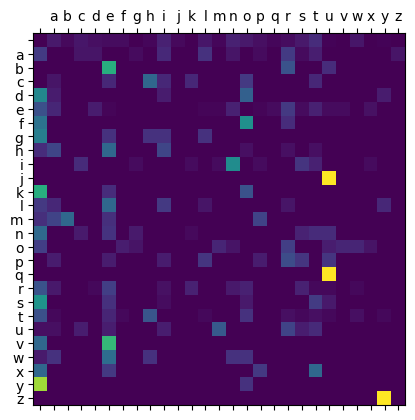

In [4]:
# let's train a markov chain on this text!

def train_char_markov_chain(
	text: str,
	vocab: list[str],
) -> Float[np.ndarray, "d_vocab d_vocab"]:

	text = "".join(clean_text(text))

	vocab_size = len(vocab)
	chain: Float[np.ndarray, "d_vocab d_vocab"] = np.zeros((vocab_size, vocab_size))

	for i in range(len(text) - 1):
		char1 = text[i]
		char2 = text[i + 1]
		chain[vocab.index(char1), vocab.index(char2)] += 1
	
	chain /= chain.sum(axis=1, keepdims=True)

	return chain


char_chain = train_char_markov_chain(some_text, char_vocab)

def plot_char_chain(chain: Float[np.ndarray, "d_vocab d_vocab"]):
	plt.matshow(chain)
	# add vocab labels
	plt.xticks(range(len(char_vocab)), char_vocab)
	plt.yticks(range(len(char_vocab)), char_vocab)
	plt.show()

plot_char_chain(char_chain)

Now, what does this chain predict?

In [5]:
def char_generate(
	prompt: str,
	chain: Float[np.ndarray, "d_vocab d_vocab"],
	vocab: list[str],
	max_new_chars: int = 100,
) -> list[str]:

	output = list(prompt)

	for i in range(max_new_chars):
		c = output[-1]
		c_idx = vocab.index(c)
		next_letter_probabilities = chain[c_idx]
		c_next = np.random.choice(vocab, p=next_letter_probabilities)
		# c_next = vocab[next_letter_probabilities.argmax()]
		output.append(c_next)

	return "".join(output)

print(char_generate("the ", char_chain, char_vocab, 100))

the brequitowe in lerov ain jumbr fort tove ouripral he les a n din malaly inenteer nchacelea wan ik ctw


so, clearly, that doesn't work great. What can we learn from that markov chain though?

In particular, what happens when we keep running it forever?

What we did previously was assume a single initial state. However, we can also assume a *distribution* over initial states. If we, for example, assume a uniform distribution $p$ over the initial states:

$$ p[i] = \frac{1}{d_{\texttt{vocab}}} $$

then we can just multiply our matrix by this distribution to get the distribution over the next state:

$$ p_{t+1} = M p_t $$

So what happens as we take the iteration $t \to \infty$? If $M^\infty$ converges, then we can just say

$$ p_* = M^\infty p_* = M p_* $$

does that remind you of anything?

Recall the definition of an eigenvector $v$ with eigenvalue $\lambda$ for some matrix $A$:

$$ A v = \lambda v $$

In our case, $\lambda = 1$, and $v = p_*$.

In [6]:
def compute_chain_eig(
	chain: Float[np.ndarray, "d_vocab d_vocab"],
):
	eigvals, eigvecs = np.linalg.eig(chain)
	return eigvals, eigvecs

eigvals, eigvecs = compute_chain_eig(char_chain)

for eL, eV in zip(eigvals, eigvecs):
	# check the real part of the eigenvalue is 1 and the imaginary part is 0
	if np.isclose(eL.real, 1) and np.isclose(eL.imag, 0):
		for c, v in zip(char_vocab, eV):
			# print the magnitude of the eigenvector
			print(f"{c}: {v.real:.3f}")
			pass

 : 0.192
a: -0.069
b: -0.069
c: 0.042
d: 0.042
e: -0.034
f: -0.034
g: 0.023
h: 0.023
i: -0.026
j: -0.026
k: 0.011
l: -0.018
m: -0.018
n: -0.047
o: 0.015
p: 0.015
q: 0.006
r: 0.006
s: -0.007
t: -0.007
u: 0.002
v: -0.001
w: 0.000
x: -0.000
y: -0.000
z: -0.000


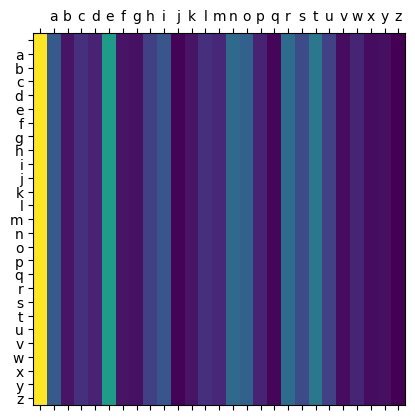

In [7]:
plot_char_chain(np.linalg.matrix_power(char_chain, 10))

You might be asking what any of this markov chain stuff has to do with neural networks -- but we can actually think of a markov chain as a single-layer neural network (with no bias):

$$
	y = M x
$$



In [8]:
mm("""
graph LR;
	in([input])
	lin[[Linear]]
	out([output])
	in-->lin;
	lin-->out;
""")

# Excercise: Markov Chain as a Neural Network
Implement a markov chain as a pytorch module, train it, and compare the weights you get 

In [9]:

class MarkovChain(torch.nn.Module):
	def __init__(
		self,
		vocab_arr: list[str],
	):
		super().__init__()
		self.vocab_arr: list[str] = vocab_arr
		self.d_vocab: int = len(vocab_arr)
		self.vocab_dict: dict[str, int] = {c: i for i, c in enumerate(vocab_arr)}

		self.linear: torch.nn.Module = None # TODO

	def forward(
		self,
		x: Int[torch.Tensor, "d_vocab"],
	) -> Float[torch.Tensor, "d_vocab"]:
		output = None # TODO
		return output
	
	def generate(
		self,
		prompt: list[str],
		max_new_chars: int = 100,
	) -> str:
		output: list[str] = prompt

		for i in range(max_new_chars):
			c: str = None # TODO
			c_idx: int = None # TODO
			next_letter_probabilities: Float[torch.Tensor, "d_vocab"] = None # TODO
			c_next: str = None # TODO
			output.append(c_next)

		return "".join(output)

def train_torch_chain(
	data: list[str],
	vocab: list[str],
	n_epochs: int = 100,
	batch_size: int = 32,
) -> MarkovChain:
	
	chain: MarkovChain = MarkovChain(vocab)
	optimizer = torch.optim.Adam(chain.parameters(), lr=1e-3)
	loss_fn = torch.nn.CrossEntropyLoss()

	for e in range(n_epochs):
		for i in range(0, len(data) // batch_size): # this skips the last batch if it's not the right size, whatever
			batch = data[i * batch_size: (i + 1) * batch_size]

			predictions = None # TODO
			targets = None


	return chain


# Tokenization

In practice, character-level encoding comes with a tradeoff: you have a very small vocabulary, but you need a very long sequence to encode any meaningful information.
We want to give our system a useful *prior:* most of the time, in natural language, letters only appear in certain sequences which we call *words.*

The simplest way to tokenize is just to split the text by spaces into words (treating all punctuation as a unique word). This gives you some weird looking sequences, but its a good start.

If we want to explore tokenization, we first need a real dataset.


## Getting data
gutenberg books has a lot of public domain books. the code below will download a selected few books.

In [10]:
def get_gutenberg_book(
	id: int|None = 84,
	data_temp: Path|str = "../data/gutenberg_data",
	remove_gutenberg_meta: bool = True,
) -> str:
	
	data_temp = Path(data_temp)
	data_temp.mkdir(parents=True, exist_ok=True)
	
	url: str = f"https://www.gutenberg.org/cache/epub/{id}/pg{id}.txt"
	data_path: Path = Path(data_temp) / f"{id}.txt"
	data: str
	# read from cache if it exists
	if data_path.exists():
		with open(data_path, 'r', encoding='utf-8') as file:
			data = file.read()
	else:
		# download if it doesn't exist
		response = requests.get(url)
		response.raise_for_status()  # Ensure that the download was successful
		data = response.text

		# save to cache
		with open(data_path, 'w', encoding='utf-8') as file:
			file.write(data)

	# remove header/footer
	if remove_gutenberg_meta:
		data = '***'.join(data.split('***')[2:])
		data = '***'.join(data.split('***')[:-1])
	
	return data

def get_many_books(
		ids: list[int],
		data_temp: Path|str = "../data/gutenberg_data",
	) -> list[str]:
	
	data: list[str] = []
	for id in ids:
		print(f"Getting book {id}...")
		item: str = get_gutenberg_book(id, data_temp)
		print(f"\t{len(item)} characters read")
		data.append(item)
	
	return data

In [11]:
DATA_RAW: list[str] = get_many_books([84, 15, 18, 82, 996, 2600])

print(f"{sum(len(x) for x in DATA_RAW) = }")

Getting book 84...
	426812 characters read
Getting book 15...
	1241057 characters read
Getting book 18...
	1191616 characters read
Getting book 82...
	1125004 characters read
Getting book 996...
	2342280 characters read
Getting book 2600...
	3274016 characters read
sum(len(x) for x in DATA_RAW) = 9600785


In [12]:
f"{DATA_RAW[0][10_000:10_500]}"

', to word my phrase\n\nmore characteristically, of advancement in his profession. He is an\n\nEnglishman, and in the midst of national and professional prejudices,\n\nunsoftened by cultivation, retains some of the noblest endowments of\n\nhumanity. I first became acquainted with him on board a whale vessel;\n\nfinding that he was unemployed in this city, I easily engaged him to assist\n\nin my enterprise.\n\n\n\nThe master is a person of an excellent disposition and is remarkable in the\n\nship for his gentleness'

## preprocessing data

as you can see, the above text has a lot of things we don't *really* care all that much about. Things like whitespace, punctuation, and capitalization. We can remove these things to make our lives easier.

In [13]:
def process_text(
	text: str,
	allowed_punctuation: str = "-.,;:!?()\"" + "".join(str(x) for x in range(10)),
	punctuation_convert: dict[str,str] = {'—': '-'},
) -> str:
	
	# replace some special characters which unicode won't normalize properly
	for char, replacement in punctuation_convert.items():
		text = text.replace(char, replacement)

	# if a line has ".jpg" in it, remove that line (this is specific to Don Quixote)
	text = '\n'.join(
		line 
		for line in text.split('\n')
		if '.jpg' not in line
	)

	# Normalize the string to decompose Unicode characters
	text = unicodedata.normalize('NFKD', text)

	# Encode to ASCII bytes, then decode back to string, ignoring errors
	text = text.encode('ascii', 'ignore').decode('ascii')

	# remove newlines and tabs
	text = text.replace('\n', ' ').replace('\t', ' ')


	# put spaces around allowed punctuation
	for char in allowed_punctuation:
		text = text.replace(char, f' {char} ')


	# remove leading and trailing spaces
	text = text.strip()

	# remove multiple spaces
	while '  ' in text:
		text = text.replace('  ', ' ')


	# remove all characters except (alphanumeric, allowed_punctuation, ' ')
	text = ''.join(
		(
			char 
			if (
				char.isalnum() 
				or char in allowed_punctuation 
				or char == ' '
			)
			else ' '
		)
		for char in text 
	)

	# convert to lowercase
	text = text.lower()

	text = text.strip()

	return text


In [14]:
DATA: str = " ".join(process_text(x) for x in DATA_RAW)

print(DATA[:1000])

frankenstein ; or , the modern prometheus by mary wollstonecraft ( godwin ) shelley contents letter 1 letter 2 letter 3 letter 4 chapter 1 chapter 2 chapter 3 chapter 4 chapter 5 chapter 6 chapter 7 chapter 8 chapter 9 chapter 1 0 chapter 1 1 chapter 1 2 chapter 1 3 chapter 1 4 chapter 1 5 chapter 1 6 chapter 1 7 chapter 1 8 chapter 1 9 chapter 2 0 chapter 2 1 chapter 2 2 chapter 2 3 chapter 2 4 letter 1  to mrs . saville , england .   st . petersburgh , dec . 1 1 th , 1 7 - . you will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings . i arrived here yesterday , and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking . i am already far north of london , and as i walk in the streets of petersburgh , i feel a cold northern breeze play upon my cheeks , which braces my nerves and fills me with delight . do you understand this feeling ? this bre

## character-level chain

just for fun

In [15]:
char_chain_bigdata = train_char_markov_chain(DATA, char_vocab)

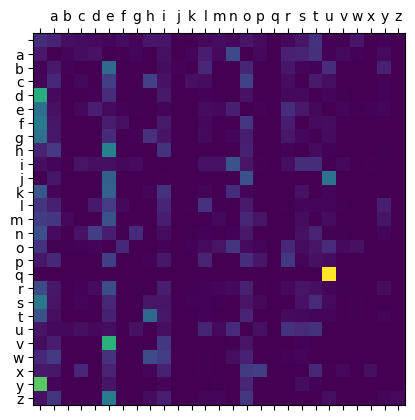

In [16]:
plt.matshow(char_chain_bigdata)
# add vocab labels
plt.xticks(range(len(char_vocab)), char_vocab)
plt.yticks(range(len(char_vocab)), char_vocab)
plt.show()

## Coming up with a Vocabulary

vocab_size = 35747
vocab_freq.most_common(10) = [(',', 133768), ('the', 107956), ('.', 60900), ('and', 60715), ('of', 57735), ('to', 50135), ('a', 31608), ('in', 28965), ('that', 24474), ('he', 20461)]
vocab_freq.most_common()[-10:] = [('interconnected', 1), ('geographic', 1), ('ethnographic', 1), ('philology', 1), ('geology', 1), ('subverting', 1), ('provokes', 1), ('joshua', 1), ('uninvited', 1), ('immovability', 1)]
vocab_length_sorted[:10] = ['', ';', ',', '(', ')', '1', '2', '3', '4', '5']
vocab_length_sorted[-10:] = ['circumstantiality', 'straightforwardly', 'misunderstandings', 'unapproachability', 'contemporaneously', 'characteristically', 'misrepresentations', 'contradistinguished', 'anycounterbalancing', 'uninterpenetratingly']


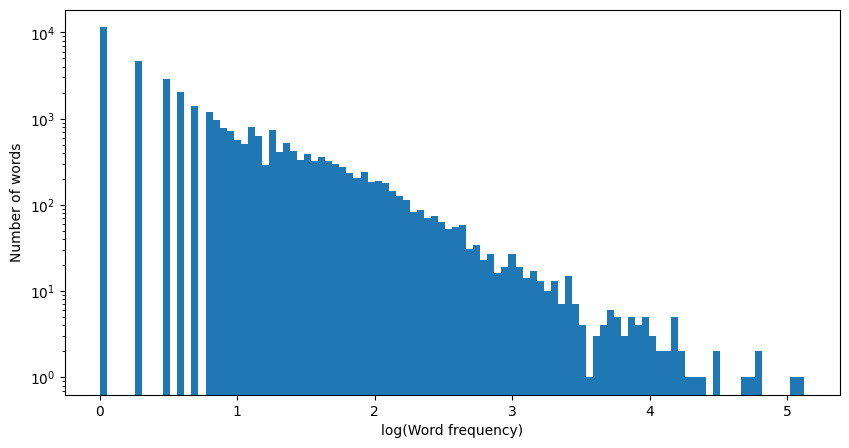

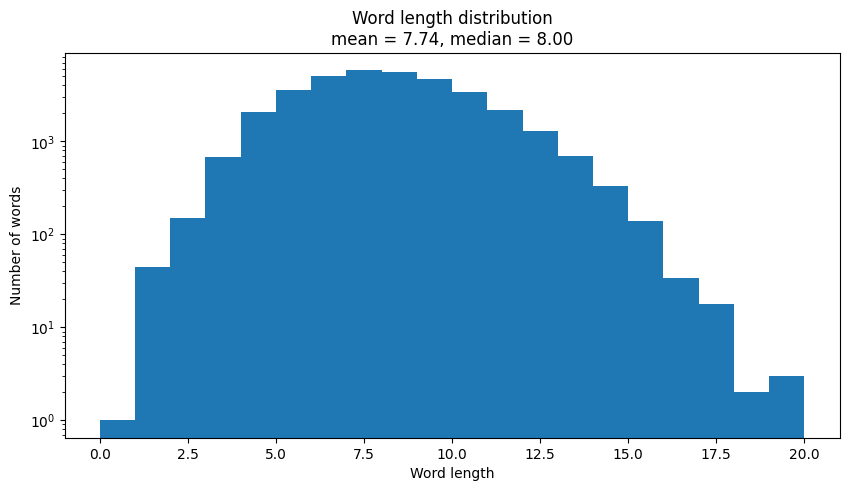

11492 words with frequency 1
4663 words with frequency 2
2846 words with frequency 3


In [17]:
def tokenize(
	text: str,
	process: bool = False,
) -> list[str]:
	if process:
		text = process_text(text)
	return text.split(' ')

DATA_TOKENIZED: list[str] = tokenize(DATA)

def analyze_vocab(
	tokenized_text: list[str],
) -> Counter[str]:

	vocab_freq: Counter[str] = Counter(tokenized_text)
	vocab_size: int = len(vocab_freq)

	print(f"{vocab_size = }")
	print(f"{vocab_freq.most_common(10) = }")
	print(f"{vocab_freq.most_common()[-10:] = }")

	# get longest and shortest words
	vocab_length_sorted: list[str] = sorted(vocab_freq.keys(), key=len)
	print(f"{vocab_length_sorted[:10] = }")
	print(f"{vocab_length_sorted[-10:] = }")

	# plot histogram of word frequencies
	plt.figure(figsize=(10, 5))
	plt.hist(np.log10(np.array(list(vocab_freq.values()))), bins=100, log=True)
	plt.yscale('log')
	plt.xlabel("log(Word frequency)")
	plt.ylabel("Number of words")
	plt.show()

	# plot histogram of word lengths
	word_lengths = np.array([len(x) for x in vocab_freq.keys()])
	plt.figure(figsize=(10, 5))
	plt.hist(word_lengths, bins=20, log=True)
	plt.yscale('log')
	plt.xlabel("Word length")
	plt.ylabel("Number of words")
	plt.title(f"Word length distribution\nmean = {word_lengths.mean():.2f}, median = {np.median(word_lengths):.2f}")
	plt.show()

	return vocab_freq

VOCAB_FREQ: Counter[str] = analyze_vocab(DATA_TOKENIZED)
WORDS_BY_FREQ: dict[int, list[str]] = {
	freq: [
		word 
		for word, word_freq in VOCAB_FREQ.items() 
		if word_freq == freq
	]
	for freq in set(VOCAB_FREQ.values())
}

for freq in range(1, 4):
	print(f"{len(WORDS_BY_FREQ[freq])} words with frequency {freq}")


In [18]:
# print a random sample of the once-used words
print(np.random.choice(WORDS_BY_FREQ[1], size=100))

['soporific' 'tay' 'purchass' 'anathemas' 'heedlessly' 'feminam'
 'obstructing' 'lentils' 'blanketers' 'reborn' 'indelibly' 'amphictyon'
 'diese' 'bruces' 'renovating' 'brotherhoods' 'helpmate' 'lenfant'
 'preorgatives' 'houris' 'redhanded' 'scotfree' 'plugs' 'libyas'
 'entretenimiento' 'refastened' 'cardiffe' 'tantalization' 'falkland'
 'unconfirmed' 'spicin' 'slights' 'calle' 'undertakers' 'woodpecker'
 'welkin' 'pelissier' 'limes' 'helmsmans' 'corporation' 'scrolls' 'fames'
 'obtuseness' 'seekers' 'pendulum' 'slits' 'senselessness' 'corporation'
 'evading' 'outweighs' 'brownish' 'onsets' 'mutinying' 'danser' 'valve'
 'doled' 'blends' 'thrash' 'swines' 'hermangild' 'jeffersons' 'cornfield'
 'countermanded' 'marring' 'azor' 'squeamishly' 'communis' 'gaetas'
 'gaudeamus' 'folger' 'patten' 'bloodless' 'lodi' 'perpetrator' 'arevalo'
 'conferences' 'interchanging' 'abreg' 'liken' 'chequers' 'mobbed'
 'anatomise' 'vae' 'irradiate' 'ian' 'stigmatize' 'livings' 'cherub'
 'diligite' 'verbatim

## Encoding & Decoding

In [19]:
# sorted by frequency
VOCAB_ARR: list[str] = [word for word, _ in VOCAB_FREQ.most_common()]
VOCAB_DICT: dict[str, int] = {word: i for i, word in enumerate(VOCAB_ARR)}

def encode(
	text: str|list[str],
) -> Int[np.ndarray, "n_tokens"]:
	if isinstance(text, str):
		text = tokenize(text)
	return np.array([VOCAB_DICT[word] for word in text])

def decode(
	encoded_text: list[int],
) -> str:
	return ' '.join(VOCAB_ARR[i] for i in encoded_text)

DATA_ENCODED: Int[np.ndarray, "n_tokens"] = encode(DATA)

print(f"{DATA_ENCODED[:10] = }")

DATA_ENCODED[:10] = array([ 4674,    13,    40,     0,     1,  1587, 12123,    27,   278,
       24255])


## Word-level chain

In [20]:
def train_markov_chain(
	vocab_size: int,
	data_encoded: Int[np.ndarray, "n_tokens"],
) -> Float[np.ndarray, "d_vocab d_vocab"]:

	# initialize matrix
	chain: Float[np.ndarray, "d_vocab d_vocab"] = np.zeros(
		(vocab_size, vocab_size),
		dtype=np.float32,
	)

	# count transitions
	for i in range(len(data_encoded) - 1):
		chain[data_encoded[i], data_encoded[i+1]] += 1

	# normalize
	chain = chain / chain.sum(axis=1, keepdims=True)

	return chain

CHAIN: Float[np.ndarray, "d_vocab d_vocab"] = train_markov_chain(
	vocab_size=len(VOCAB_ARR),
	data_encoded=DATA_ENCODED,
)

print(f"{CHAIN.shape = }")

CHAIN.shape = (35747, 35747)


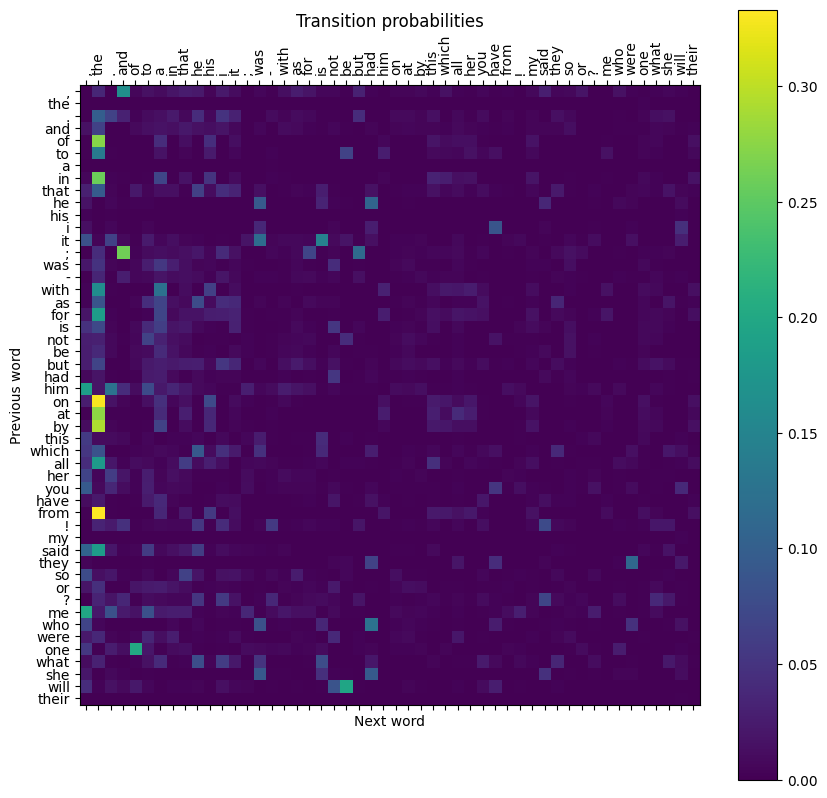

In [21]:
def plot_chain_subset(
	chain: Float[np.ndarray, "d_vocab d_vocab"],
	vocab_dict: dict[str, int],
	vocab_subset: list[str],
	exponentiate: int = 1,
) -> None:
	fig, ax = plt.subplots(figsize=(10, 10))
	
	# get indices of words in subset
	vocab_subset_idx: list[int] = [vocab_dict[word] for word in vocab_subset]

	# plot subset of chain
	chain_subset: Float[np.ndarray, "d_vocab_subset d_vocab_subset"] = chain[np.ix_(vocab_subset_idx, vocab_subset_idx)]

	if exponentiate != 1:
		chain_subset = np.linalg.matrix_power(chain_subset, exponentiate)

	img = ax.matshow(chain_subset)
	ax.set_title("Transition probabilities")
	ax.set_xlabel("Next word")
	ax.set_ylabel("Previous word")
	# label axes with words
	ax.set_xticks(range(len(vocab_subset)))
	ax.set_xticklabels(vocab_subset, rotation=90)
	ax.set_yticks(range(len(vocab_subset)))
	ax.set_yticklabels(vocab_subset)
	
	# add colorbar
	fig.colorbar(img)
	
	plt.show()

plot_chain_subset(
	chain=CHAIN,
	vocab_dict=VOCAB_DICT,
	vocab_subset=VOCAB_ARR[:50],
	# exponentiate=10,
)

In [34]:
print(CHAIN.shape)
np.save("chain.npy", CHAIN)
json.dump(VOCAB_ARR, open("vocab.json", "w"))

(35747, 35747)


In [37]:
# do the svd of chain
U, S, V = np.linalg.svd(CHAIN.astype(np.float32))
np.savez(
	"svd.npz",
	U=U,
	S=S,
	V=V,
)

MemoryError: Unable to allocate 9.52 GiB for an array with shape (35747, 35747) and data type float64

In [22]:
def chain_generate(
	context: str|list[str]|Int[np.ndarray, "n_tokens"],
	chain: Float[np.ndarray, "d_vocab d_vocab"],
	max_new_tokens: int,
	vocab_dict: dict[str, int],
	return_encoded: bool = False,
) -> str:
	if isinstance(context, str):
		context = tokenize(context, process=True)
	if isinstance(context, list):
		context = encode(context)

	# for easier appending
	context = context.tolist()

	# get the probabilities of the next word
	for i in range(max_new_tokens):
		context.append(
			np.random.choice(
				len(vocab_dict),
				p=chain[context[-1]],
			)
		)
	
	if return_encoded:
		return context
	else:
		return decode(context)

chain_generate(
	context="of the",
	chain=CHAIN,
	max_new_tokens=20,
	vocab_dict=VOCAB_DICT,
)

'of the prospect of some venison season , as the heart , and which warrant in practice might have it i pray'

# Advanced tokenization

In reality, language is really complex. We also don't want to strip things like capitalization or punctuation, and we want to be able to create compound words out of root words, suffixes, and prefixed. Although probably far from optimal, the current most popular algorithm used to come up with a token vocabulary is *byte-pair encoding.*.

In [23]:
def get_most_frequent_pair(vocab):
    return max(vocab, key=vocab.get)

def byte_pair_encoding(tokens, num_merges):
    """
    Implement Byte Pair Encoding.

    Args:
    tokens (list of str): The input tokens to be compressed.
    num_merges (int): Number of merge operations to perform.

    Returns:
    tuple: Compressed tokens and the token vocabulary mapping.
    """

    # Initialize vocabulary with token pairs
    token_pairs = [tokens[i:i+2] for i in range(len(tokens)-1)]
    vocab = Counter(map(tuple, token_pairs))

    # Initialize the token vocabulary
    token_vocab = {}

    for i in range(num_merges):
        most_frequent = get_most_frequent_pair(vocab)

        # If frequency is less than 2, break the loop
        if vocab[most_frequent] < 2:
            break

        # Create a new token
        new_token = f'Z{(26 - i) % 26}'  # ZYX... cycle
        token_vocab[new_token] = ''.join(most_frequent)

        # Update tokens by merging the most frequent pair
        new_tokens = []
        skip_next = False
        for j in range(len(tokens)):
            if skip_next:
                skip_next = False
                continue

            if j < len(tokens) - 1 and tokens[j] == most_frequent[0] and tokens[j + 1] == most_frequent[1]:
                new_tokens.append(new_token)
                skip_next = True
            else:
                new_tokens.append(tokens[j])

        tokens = new_tokens

        # Update the vocabulary
        new_vocab = Counter()
        for j in range(len(tokens) - 1):
            new_vocab[tuple(tokens[j:j+2])] += 1
        vocab = new_vocab

    return tokens, token_vocab

# Test the function with list of tokens
test_tokens = list("ababcbabcdcd")
compressed_tokens, token_vocab = byte_pair_encoding(test_tokens, 10)

compressed_tokens, token_vocab



(['Z0', 'Z25', 'b', 'Z25', 'd', 'c', 'd'], {'Z0': 'ab', 'Z25': 'Z0c'})

# Unigrams, Bigrams, and N-grams

A fundamental problem that remains is that everything we've build so far looks only at the most recent token (whether that be a word or a character).

In reality, human language does not satisfy the markov property. So, we want to be able to give the system a *sequence* of tokens.

Recall our previous formalization of a markov chain as a neural network $h$:

$$ h_\theta(x_t) = M x_t $$
$$ \hat{\theta} = \argmin_\theta \mathbb{E}_{x_t, x_{t+1} \in D} \Vert h_\theta(x_t), x_{t+1} \Vert $$

where $x_t$ is a one-hot vector encoding the current token.

Recall that this means that for a vocabulary size of $d_v$, we have that $M \in R^{d_v \times d_v}$.


In [24]:
mm("""
graph LR;
	x0(["x[t]"])
	M[[M]]
	x1(["x[t+1]"])
	x0-->M;
	M-->x1;
""")

A tempting thing is just to include another state in the input to the matrix. This gives us a matrix $M \in R^{d_v \times d_v^2}$, where $d_v^2$ is the size of the vocabulary of all possible *bigrams*.

In [25]:
mm("""
graph LR;
	x0(["x[t-1]"])
	x1(["x[t]"])
	M[[M]]
	xn(["x[t+1]"])
	x0-->M;
	x1-->M;
	M-->xn;
""")

we can actually extend this to what is known as an $n$-gram model, where we look at the previous $n$ tokens. This gives us a matrix $M \in R^{d_v \times d_v^n}$.

In [26]:
mm("""
graph LR;
	xtn(["x[t-n]"])
	xdd(((...)))
	xt1(["x[t-1]"])
	xt(["x[t]"])
	xk(["x[t+1]"])
	M[[M]]
	xtn-->M;
	xdd-->M;
	xt1-->M;
	xt-->M;
	M-->xk;
""")

Now, let's say we want to try something conservative like a sequence length of 128, with a vocabulary size of 30 (letters, spaces, some basic punctuation). This gives us a matrix $M \in R^{30 \times 30^{128}}$:

In [27]:
mat_elements = 30 * (30 ** 128)
print(f"{mat_elements = }")
print(f"{mat_elements = :.2e}")

mat_elements = 35370553733215749514562618584237555997034634776827523327290883000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
mat_elements = 3.54e+190


This is **vastly** beyond the capabilities of any computer to store -- its more than the *number of particles in the universe, **squared***


Let's say we have a really good tokenization scheme and don't care about obscure words, and we only have $d_v = 16000$ tokens in our vocabulary. With an average word length of 8, let's say we need 16 tokens to approximate 128 characters. This gives us a matrix $M \in R^{16000 \times 16000^{16}}$:

In [28]:
mat_elements_tokenized = 16000 * (16000 ** 16)
print(f"{mat_elements_tokenized = }")
print(f"{mat_elements_tokenized = :.2e}")


mat_elements_tokenized = 295147905179352825856000000000000000000000000000000000000000000000000000
mat_elements_tokenized = 2.95e+71


so... a bit better, but still unimaginably huge (about 18 orders of magnitude more than the total mass of the observable universe in kg).

# Recurrent Neural Networks

Thinking back to our $n$-gram model:

In [29]:
mm("""
graph LR;
	xtn(["x[t-n]"])
	xdd(((...)))
	xt1(["x[t-1]"])
	xt(["x[t]"])
	xk(["x[t+1]"])
	M[[M]]
	xtn-->M;
	xdd-->M;
	xt1-->M;
	xt-->M;
	M-->xk;
""")

what if we gave the model the *prior* that each token needs the same sort of preprocessing? We call this an *embedding*.

In [30]:
mm("""
graph LR;
	xtn(["x[t-n]"])
	xdd(((...)))
	xt1(["x[t-1]"])
	xt(["x[t]"])
	xk(["x[t+1]"])
	E[[Embedding]]
	M[[M]]
	xtn-->E;
	xdd-->E;
	xt1-->E;
	xt-->E;
	E-->M;
	M-->xk;
""")

However, we can compute that for any reasonable embedding size, the number of parameters in our model is still going to be huge -- the problem is that we are learning a *unique* map for each position in the sequence -- just like our dense net was learning a unique map for each pixel in the image. What if we structured the network so that it could *share* parameters across positions in the sequence?

In [31]:
mm("""
graph LR;
	xtn(["x[t-n]"])
	xdd(((...)))
	xt1(["x[t-1]"])
	xt(["x[t]"])
	xk(["x[t+1]"])
	Etn[[Embedding]]
	Edd[[Embedding]]
	Et1[[Embedding]]
	Et[[Embedding]]
	xtn-->Etn;
	xdd-->Edd;
	xt1-->Et1;
	xt-->Et;
	htn[[h]];
	hdd[[h]];
	ht1[[h]];
	ht[[h]];
	Etn-->htn;
	htn--"q[t-n]"-->hdd;
	Edd-->hdd;
	hdd--"q[...]"-->ht1;
	Et1-->ht1;
	ht1--"q[t-1]"-->ht;
	Et-->ht;
	ht-->xk;
""")

This is what we term a *Recurrent Neural Network* -- it has a hidden state $q$, computed by some network $h$, which is a function both of the previous hidden state and the current input:

$$
	\texttt{RNN}([x_{t+1}, \ldots, x_{t-n}]) = h(x_{t+1}, q_{t})
	\qquad
	q_{t} = h(x_{t}, q_{t-1})
$$

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import List

# Defining the BasicRNN class
class BasicRNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, layer_sizes: List[int]):
        super(BasicRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_dim = hidden_dim

        # keep track of the hidden state

        # Create the dense layers
        # TODO

        # de-embeddings
        # TODO


    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        # TODO
        # randomly init hidden state
        # pass all tokens through embedding
        # update hidden state sequentially
        # produce output from hidden state for all tokens

    def generate(self, start_token: int, max_length: int = 100) -> List[int]:
        # TODO

# Initialize the model and optimizer
model = BasicRNN(100, 50, 100, [200, 150])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy training data
# Using a simple sequence of numbers as dummy text
dummy_text = list(range(20))  # Simple sequence of numbers
input_tokens = torch.tensor(dummy_text[:-1])  # All tokens except the last
target_tokens = torch.tensor(dummy_text[1:])  # All tokens except the first

# Training loop
model.train()
optimizer.zero_grad()
output = model(input_tokens)
loss = F.nll_loss(output, target_tokens)
loss.backward()
optimizer.step()

output


IndentationError: expected an indented block after function definition on line 23 (2435151573.py, line 30)

# old

## Shakespeare

you might need to install the beautifulsoup4 package first:
```
pip install beautifulsoup4
```

In [ ]:

import zipfile
from io import BytesIO
from bs4 import BeautifulSoup

def get_shakespeare_data(
		url: str = "https://github.com/TheMITTech/shakespeare/zipball/master",
		pattern: str = "**/full.html",
        data_temp: Path|str = "../data/shakespeare_data",
		strip_html: bool = True,
		chars_threshold: int|None = None,
	) -> dict[str, str]:
    
	data_temp = Path(data_temp)
	data_cache: Path = data_temp / "processed.json"

	# read from cache if it exists
	if data_cache.exists():
		print(f"Reading from cache...")
		with open(data_cache, 'r', encoding='utf-8') as file:
			data: dict[str,str] = json.load(file)
		print(f"Read {len(data)} files from cache with {sum(len(v) for v in data.values())} characters")
		return data

	# Download the zip file
	print(f"Downloading repo...")
	response = requests.get(url)
	response.raise_for_status()  # Ensure that the download was successful	

	# Extract the zip file into a temporary directory
	print(f"Extracting zip file...")
	with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
		zip_ref.extractall(data_temp)

	# Find all 'full.html' files
	full_html_files = list(data_temp.glob(pattern))

	# Read contents of each 'full.html' file
	data: dict[str, str] = dict()
	# open each file
	print(f"Reading files...\n")
	chars_count: int = 0
	for file_path in full_html_files:
		print(f"\t{file_path.as_posix()}")
		with open(file_path, 'r', encoding='utf-8') as file:
			# read the raw html
			content: str = file.read()

			# turn it into plain text if requested
			if strip_html:
				soup: BeautifulSoup = BeautifulSoup(content, 'html.parser')
				content = soup.get_text(separator=' ', strip=True)

			# store it in the dictionary
			data[file_path.as_posix()] = content

			chars_count += len(content)
			print(f"\t\t{chars_count} characters read")
			if chars_threshold is not None and chars_count > chars_threshold:
				break
	
	# save to cache
	print(f"Saving to cache...")
	with open(data_cache, 'w', encoding='utf-8') as file:
		json.dump(data, file, indent=4)

	return data

In [ ]:
DATA: dict[str, str] = get_shakespeare_data()

In [ ]:
print(DATA[list(DATA.keys())[0]][:1000])